# Pseudospectral tutorial, part 2
## UNCW, March 2018


A gentle stroll through pseudospectral methods: solving $\partial_t \zeta + u\partial_x\zeta + \upsilon\partial_y\zeta = \nu \nabla^2\zeta$, where $\zeta = \nabla^2\psi$, $u=-\partial_y\psi$, and $\upsilon=\partial_x\psi$.



First load the package for plotting.

In [1]:
using Pkg
Pkg.activate("../../.")

using PyPlot, Random, FFTW

We create the physical grid $x$, $y$ (as in "Part 1" notebook). Also, we create the wavenumber grid. We take $L_x=L_y=2\pi$.

In [2]:
nx, ny = 64, 64 # number of grid points
Lx, Ly = 2.0*pi, 2.0*pi      # size of the domain in each direction

# constructing the physical grid (x,y)
dx, dy = Lx/nx, Ly/ny
 x = 0:dx:Lx-dx
 y = 0:dy:Ly-dy

X  = zeros(nx,ny)
Y  = zeros(nx,ny)
for j in 1:ny, i in 1:nx
     X[i, j] = x[i]
     Y[i, j] = y[j]
end

# constructing the wavenumber grid (k,l)
k  = 2.0*pi/Lx * [0:nx/2; -nx/2+1:-1];
l  = 2.0*pi/Ly * [0:ny/2; -ny/2+1:-1];

K = zeros(nx, ny)
L = zeros(nx, ny)
for j in 1:ny, i in 1:nx
    K[i, j] = k[i]
    L[i, j] = l[j]
end

ksq = @. K^2 + L^2

invksq = 1 ./ ksq    # this is used to obtain streamfunction ψ from vorticity ζ
invksq[1,1] = 1;

Let's define some parameters.

In [3]:
nu = 3.0e-04       # kinematic viscosity coefficient (you can also use nu=8.0e-05 for n=128)
dt = 0.025         # the time step
tfin = 1000        # the final time for the integration
nstep  = Int(tfin/dt) + 1;  # the total number of time steps

t = 0:dt:tfin;     # the array with the discretized values for time

Prescribe an initial condition for $\zeta(x,y,t=0)$ and plot it.

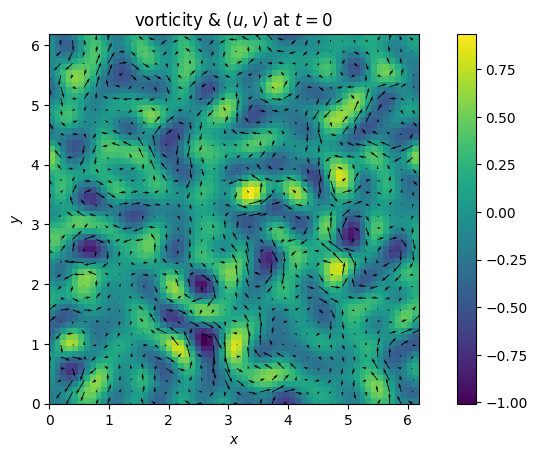

In [4]:
Random.seed!(1234)
zeta0 = randn(nx, ny)
zetah = fft(zeta0)
zetah[1, 1] = 0
zetah[@. ksq > (10)^2 ] .= 0
zetah[@. ksq < (3)^2 ] .= 0
zeta0 = real(ifft(zetah))
psih = -invksq.*zetah           # calculate \hat{ψ}
zeta =  real(ifft(zetah))       # calculate ζ(x,y,t)
u = real(ifft(-im*L.*psih))     # calculate u velocity u(x,y,t)
v = real(ifft(+im*K.*psih))     # calculate v velocity v(x,y,t)


time = 0
nc = Int(nx/32) # this variable allows us to plot arrows every nc points instead
                # of plotting an arrow at each point --- helps for better visualization

figure(1)
pcolormesh(X, Y, zeta0)
colorbar()
quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end])
xlabel(L"$x$")
ylabel(L"$y$")
title(string(L"vorticity & $(u,v)$ at $t = $", time))
axis("square")
draw();

Time-step $\zeta$ forward for `nstep` times.

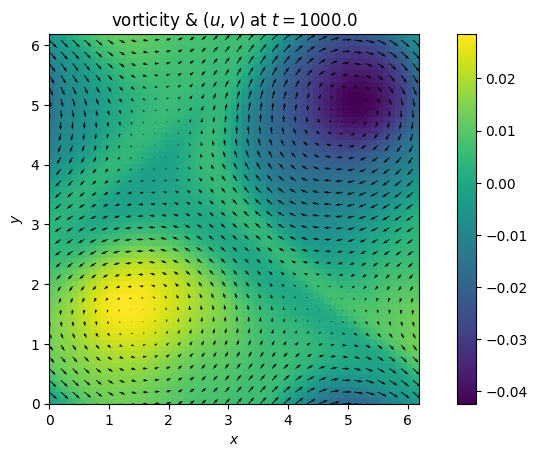

In [5]:
fig = figure()

for j = 2:nstep
    
    psih = -invksq.*zetah               # calculate \hat{ψ}
    u = real(ifft(-im*L.*psih))         # calculate u velocity
    v = real(ifft(+im*K.*psih))         # calculate v velocity
    zetax =  real(ifft(im*K.*zetah))    # calculate ∂ζ/∂x
    zetay =  real(ifft(im*L.*zetah))    # calculate ∂ζ/∂y

    # now we are ready to calculate the r.h.s. of our PDE
    rhs = -fft(u.*zetax + v.*zetay) - nu*ksq.*zetah
    
    zetah = zetah + dt*rhs         # time-step forward using the simplest Euler scheme

    if j % 200 == 1
        time = t[j]
        zeta = real(ifft(zetah))
        pcolormesh(X, Y, zeta, animated=true)
        title(string(L"vorticity at $t = $", time))
        colorbar()
        quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end])
        xlabel(L"$x$")
        ylabel(L"$y$")
        title(string(L"vorticity & $(u,v)$ at $t = $", time))
        axis("square")
        sleep(0.01)
        IJulia.clear_output(true)
        display(fig)
        clf()
    end
end

Plot the final state.

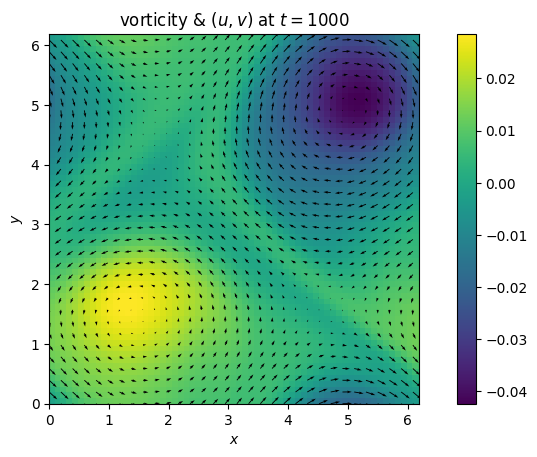

In [6]:
time = tfin
zeta = real(ifft(zetah))
psih = -invksq.*zetah               # calculate \hat{ψ}
u = real(ifft(-im*L.*psih))         # calculate u velocity
v = real(ifft(+im*K.*psih))         # calculate v velocity

figure(1)
pcolormesh(X, Y, zeta)
colorbar()
quiver(X[1:nc:end,1:nc:end], Y[1:nc:end,1:nc:end], u[1:nc:end,1:nc:end], v[1:nc:end,1:nc:end])
xlabel(L"$x$")
ylabel(L"$y$")
title(string(L"vorticity & $(u,v)$ at $t = $", time))
draw()
axis("square");